In [1]:
import torch
import numpy as np

In [2]:
from sklearn.datasets import make_blobs

In [102]:
X, y = make_blobs(n_samples=10000, n_features=2)

In [103]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


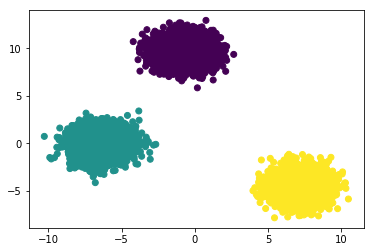

In [104]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y)

In [105]:
from torch.utils.data import Dataset

In [106]:
class BlobData(Dataset):
    def __init__(self, X, y, trans=None):
        self.data = list(zip(X, y))
        self.trans = trans
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.trans is not None:
            return self.trans(self.data[idx])
        else:
            return self.data[idx]

In [107]:
from torchvision import transforms

In [108]:
class GaussianNoise(object):
    def __init__(self, std=0.1, mean=0.0):
        self.mean = mean
        self.std = std
        
    def __call__(self, datum):
        x, y = datum[0], datum[1]
        return x + (self.std * np.random.randn(2) + self.mean), y

In [127]:
class ToTensor(object):
    def __init__(self):
          pass
        
    def __call__(self, datum):
        x, y = datum[0], datum[1]
        t = torch.from_numpy(x).type(torch.FloatTensor) 
        t.requires_grad = True
        return t, y

In [128]:
my_transform = transforms.Compose([GaussianNoise(), ToTensor()])

In [129]:
blob_dataset = BlobData(X, y, trans=my_transform)

In [130]:
len(blob_dataset)

10000

In [131]:
blob_dataset[100]

(tensor([-6.7628, -0.2773], requires_grad=True), 1)

In [132]:
import torch.nn as nn
import torch.nn.functional as F

In [133]:
class LinearWActivation(nn.Module):
    def __init__(self, in_features, out_features, activation='sigmoid'):
        super(LinearWActivation, self).__init__()
        self.f = nn.Linear(in_features, out_features)
        if activation == 'sigmoid':
            self.a = nn.Sigmoid()
        else:
            self.a = nn.ReLU()
            
    def forward(self, x):
        return self.a(self.f(x))

class MyFunnyNet(nn.Module):
    def __init__(self, layers, n_features, n_classes, activation='sigmoid'):
        super(MyFunnyNet, self).__init__()
        layers_in = [n_features] + layers 
        layers_out = layers + [n_classes]
        self.f = nn.Sequential(*[
            LinearWActivation(in_feats, out_feats, activation=activation)
            for in_feats, out_feats in zip(layers_in, layers_out)
        ])
                
    def forward(self, x):
        y = self.f(x)
        return y

In [178]:
import torch.optim as optim

EPOCHS = 30
BATCH_SZ = 32

criterion = nn.CrossEntropyLoss()
net = MyFunnyNet([100, 100], X.shape[1], len(set(y)))

In [179]:
optimizer = optim.SGD(list(net.parameters()), lr=1e-2)


In [180]:
from sklearn.model_selection import train_test_split

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [182]:
train_data = BlobData(X_train, y_train, trans=my_transform)
test_data = BlobData(X_test, y_test, trans=my_transform)

In [183]:
from torch.utils.data import DataLoader

In [184]:
train_dl = DataLoader(train_data, batch_size=BATCH_SZ)
test_dl = DataLoader(test_data, batch_size=BATCH_SZ)

In [186]:
net.train()
for epoch in range(EPOCHS):
    running_average_loss = 0
    for i, data in enumerate(train_dl):
        X_batch, y_batch = data
        optimizer.zero_grad()
        out = net(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        running_average_loss += loss.detach().item()
        if i % 100 == 0:
            print("Epoch: {} \t Batch: {} \t Loss {}".format(epoch, i, float(running_average_loss) / (i + 1)))

Epoch: 0 	 Batch: 0 	 Loss 0.5692673921585083
Epoch: 0 	 Batch: 100 	 Loss 0.5708099804302253
Epoch: 0 	 Batch: 200 	 Loss 0.5706824746297959
Epoch: 1 	 Batch: 0 	 Loss 0.5683896541595459
Epoch: 1 	 Batch: 100 	 Loss 0.569780965252678
Epoch: 1 	 Batch: 200 	 Loss 0.5696585299956858
Epoch: 2 	 Batch: 0 	 Loss 0.5675503015518188
Epoch: 2 	 Batch: 100 	 Loss 0.5688527551027808
Epoch: 2 	 Batch: 200 	 Loss 0.5687435207082264
Epoch: 3 	 Batch: 0 	 Loss 0.566669225692749
Epoch: 3 	 Batch: 100 	 Loss 0.5679839637019847
Epoch: 3 	 Batch: 200 	 Loss 0.5679031177539731
Epoch: 4 	 Batch: 0 	 Loss 0.5660101175308228
Epoch: 4 	 Batch: 100 	 Loss 0.5672055866458628
Epoch: 4 	 Batch: 200 	 Loss 0.5671442613672855
Epoch: 5 	 Batch: 0 	 Loss 0.5654624700546265
Epoch: 5 	 Batch: 100 	 Loss 0.5664927800102989
Epoch: 5 	 Batch: 200 	 Loss 0.5664265639153286
Epoch: 6 	 Batch: 0 	 Loss 0.5648099780082703
Epoch: 6 	 Batch: 100 	 Loss 0.5658371507531346
Epoch: 6 	 Batch: 200 	 Loss 0.565770448440343
Epoch: 7 

In [202]:
net.eval()
acc = 0
n_samples = 0
with torch.no_grad():
    for i, data in enumerate(test_dl):
        X_batch, y_batch = data
        out = net(X_batch)
        val, y_pred = out.max(1)
        acc += (y_batch == y_pred).sum().detach().item()
        n_samples += 32

print(acc / n_samples)

0.9915865384615384
